In [44]:
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt

# Notch filtering

We've covered bandpass filtering all ready, but it will be useful to look at an example of _notch_ filtering, which is useful for removing spectral features from your time series.  Let's start off by simulating some noise and adding a strong 60 Hz sinusoidal feature.

In [45]:
duration = 128 # signal duration
fs = 4096 # sampling rate
t = np.arange(duration*fs)/fs # sample times

f_line = 60
a_line = 10

d = np.random.randn(len(t)) + a_line * np.sin(2*np.pi*f_line*t) # mock data

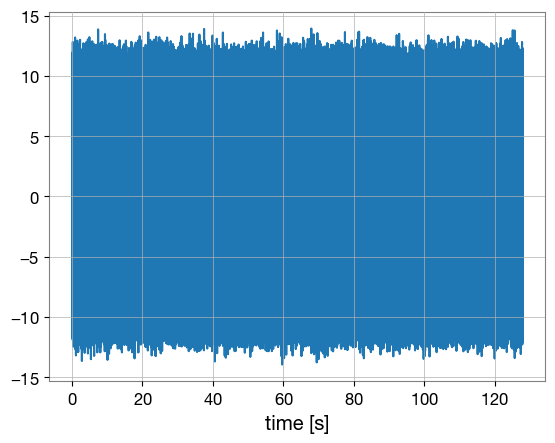

In [46]:
plt.plot(t, d)
plt.xlabel('time [s]');

It's not obvious here, but if we look at the spectrum the 60 Hz line will be pretty obvious.

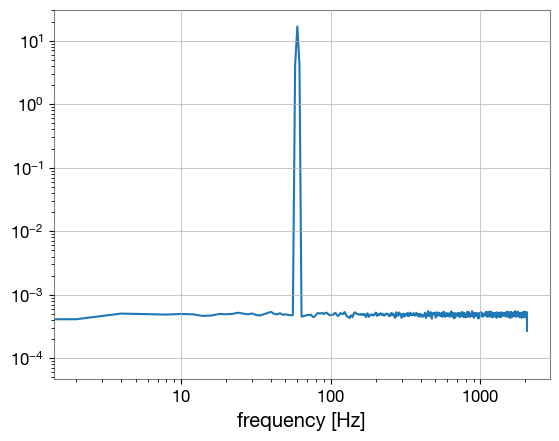

In [47]:
f, psd = signal.welch(d, fs, nperseg=.5*fs)
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]');

Let's deal with this using an IIR notch filter.  To construct the filter we'll have to choose a central frequency of the filter `f0`, and the _quality factor_ `Q` which drives the width of the filter.

We'll also redefine our butteworth filter functions for use later.

In [48]:
def iir_notch(f0, fs, Q=30):
    """Construct a notch filter at frequency f0, return numerator and
       denominator polynomials of the IIR filter."""
    b, a = signal.iirnotch(f0, Q, fs)
    return b, a

def iir_notch_filter(data, f0, fs, Q=1):
    """Filter a time series with an IIR notch filter"""
    b, a = iir_notch(f0, fs, Q=Q)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    """Construct a bandpass filter, return numerator and
       denominator polynomials of the IIR filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Filter a time series with a butteworth bandpass filter"""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

Let's use a notch filter at $60$ Hz with a quality factor of $30$.  We'll also Tukey window the data before filtering to avoid artifacts at the beginning of the filtered time series.

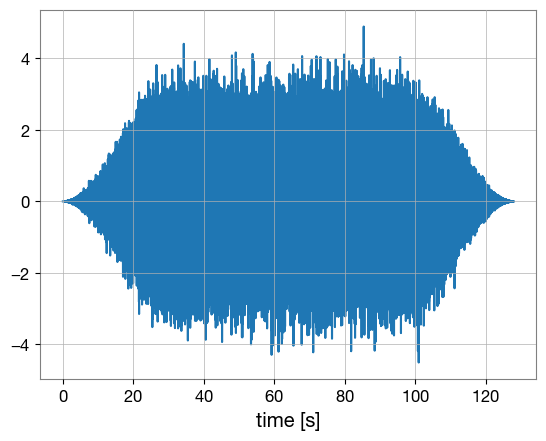

In [49]:
window = signal.tukey(len(d))
d_fil = iir_notch_filter(window*d, 60, fs, Q=30)

plt.plot(t, d_fil)
plt.xlabel('time [s]');

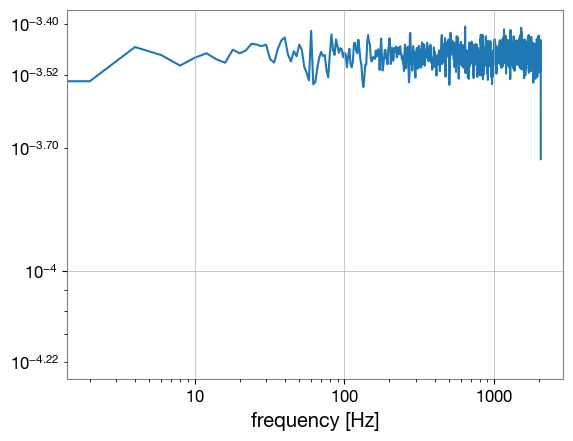

In [50]:
f, psd = signal.welch(d_fil, fs, nperseg=.5*fs)
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]');

Nice!

# Gaussian noise

Let's return to the Gaussian time series we generated, and explore some of its properties.  To be clear, this is a time series composed by drawing a random number from a $\mu=0$ $\sigma=1$ normal distribution for every sample in time.

In [51]:
duration = 128 # signal duration
fs = 4096 # sampling rate
t = np.arange(duration*fs)/fs # sample times

d = np.random.randn(len(t)) # mock data

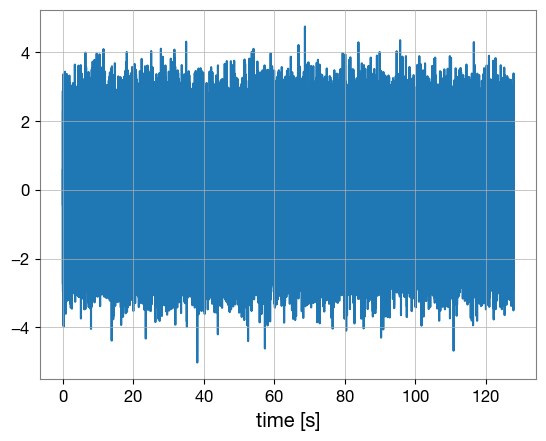

In [52]:
plt.plot(t, d)
plt.xlabel('time [s]');

Let's take a look at the power spectral density (PSD) of such a noise process.

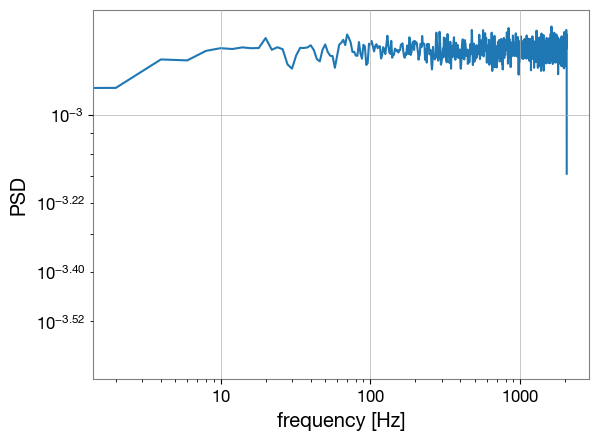

In [53]:
f, psd = signal.welch(d, fs, nperseg=.5*fs, scaling="spectrum")
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD');

This is an example of _white_ noise, making use of an analogy to light, where equal contributions from all frequencies appears white.

Let's explore some of the _statistical_ properties of this noise process in the frequency domain.  We'll do this by dividing the time series up into lots of segments, windowing them, constructing their FFT, and packing the results into a array.

In [54]:
seg_len = 1 # segment duration in seconds
window = signal.windows.hann(seg_len*fs) # window to apply to each segment
seg_freqs = np.fft.rfftfreq(fs*seg_len, 1/fs) # sample frequencies of the FFT'ed segments

freq_segs = np.empty((duration//seg_len, len(seg_freqs)), dtype='complex') # array to store frequency-domain segments
for i in range(duration//seg_len):
    freq_segs[i, :] = np.fft.rfft(window*d[i*seg_len*fs:(i+1)*seg_len*fs])

So what we have is a bunch of values of FFTs of segments for a bunch of frequency bins.  We can, for example, look at the distribution of amplitudes in the bin closest to $100$ Hz. 

/Users/bfarr/miniconda3/envs/sci-comp/lib/python3.9/site-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/bfarr/miniconda3/envs/sci-comp/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


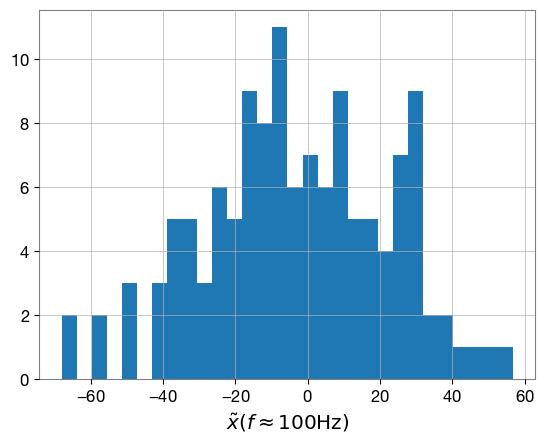

In [55]:
i = np.arange(len(seg_freqs))[seg_freqs > 100][0]
plt.hist(freq_segs[:, i], bins=30);
plt.xlabel(r'$\tilde{x}(f\approx100\mathrm{Hz})$');

Let's take at the mean of such a distribution for every frequency bin in our FFT.

/Users/bfarr/miniconda3/envs/sci-comp/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


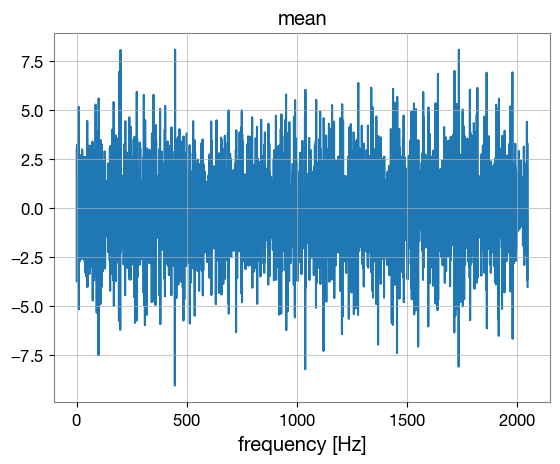

In [56]:
plt.plot(seg_freqs, np.mean(freq_segs, axis=0))
plt.title('mean')
plt.xlabel('frequency [Hz]');

So it looks like our noise process is also 0-mean in the frequency domain.

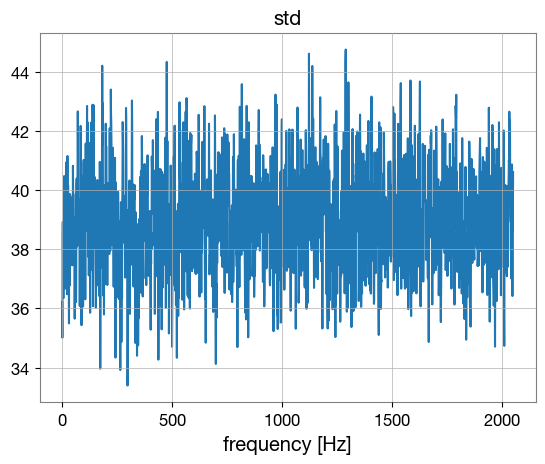

In [57]:
plt.plot(seg_freqs, np.std(freq_segs, axis=0))
plt.title('std')
plt.xlabel('frequency [Hz]');

The standard deviation is roughly constant across frequencies.  This is what we would expect for _white_ noise, and is a poorly-done estimate of our PSD (up to some normalization constant).

With this FFT'ed segments, we can also ask what the correlations are between frequency bins.  In other words, for any given segment does the value of the FFT in one frequency bin correlate with the value of in another.  We'll do this by constructing the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix).

In [81]:
np.diag(Σ)

array([1321.7542521 ,  740.04807894,  686.32357579, ...,
        680.96277228,  911.32385783, 1662.31346994])

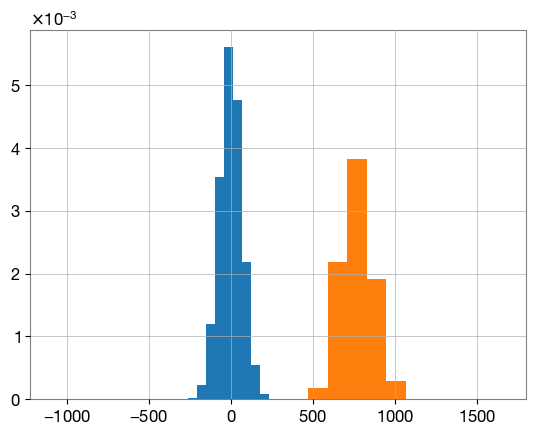

In [83]:
Σ = np.cov(freq_segs.real, rowvar=False)
plt.hist(Σ.flatten(), bins=50, density=True)
plt.hist(Σ.diagonal(), density=True);

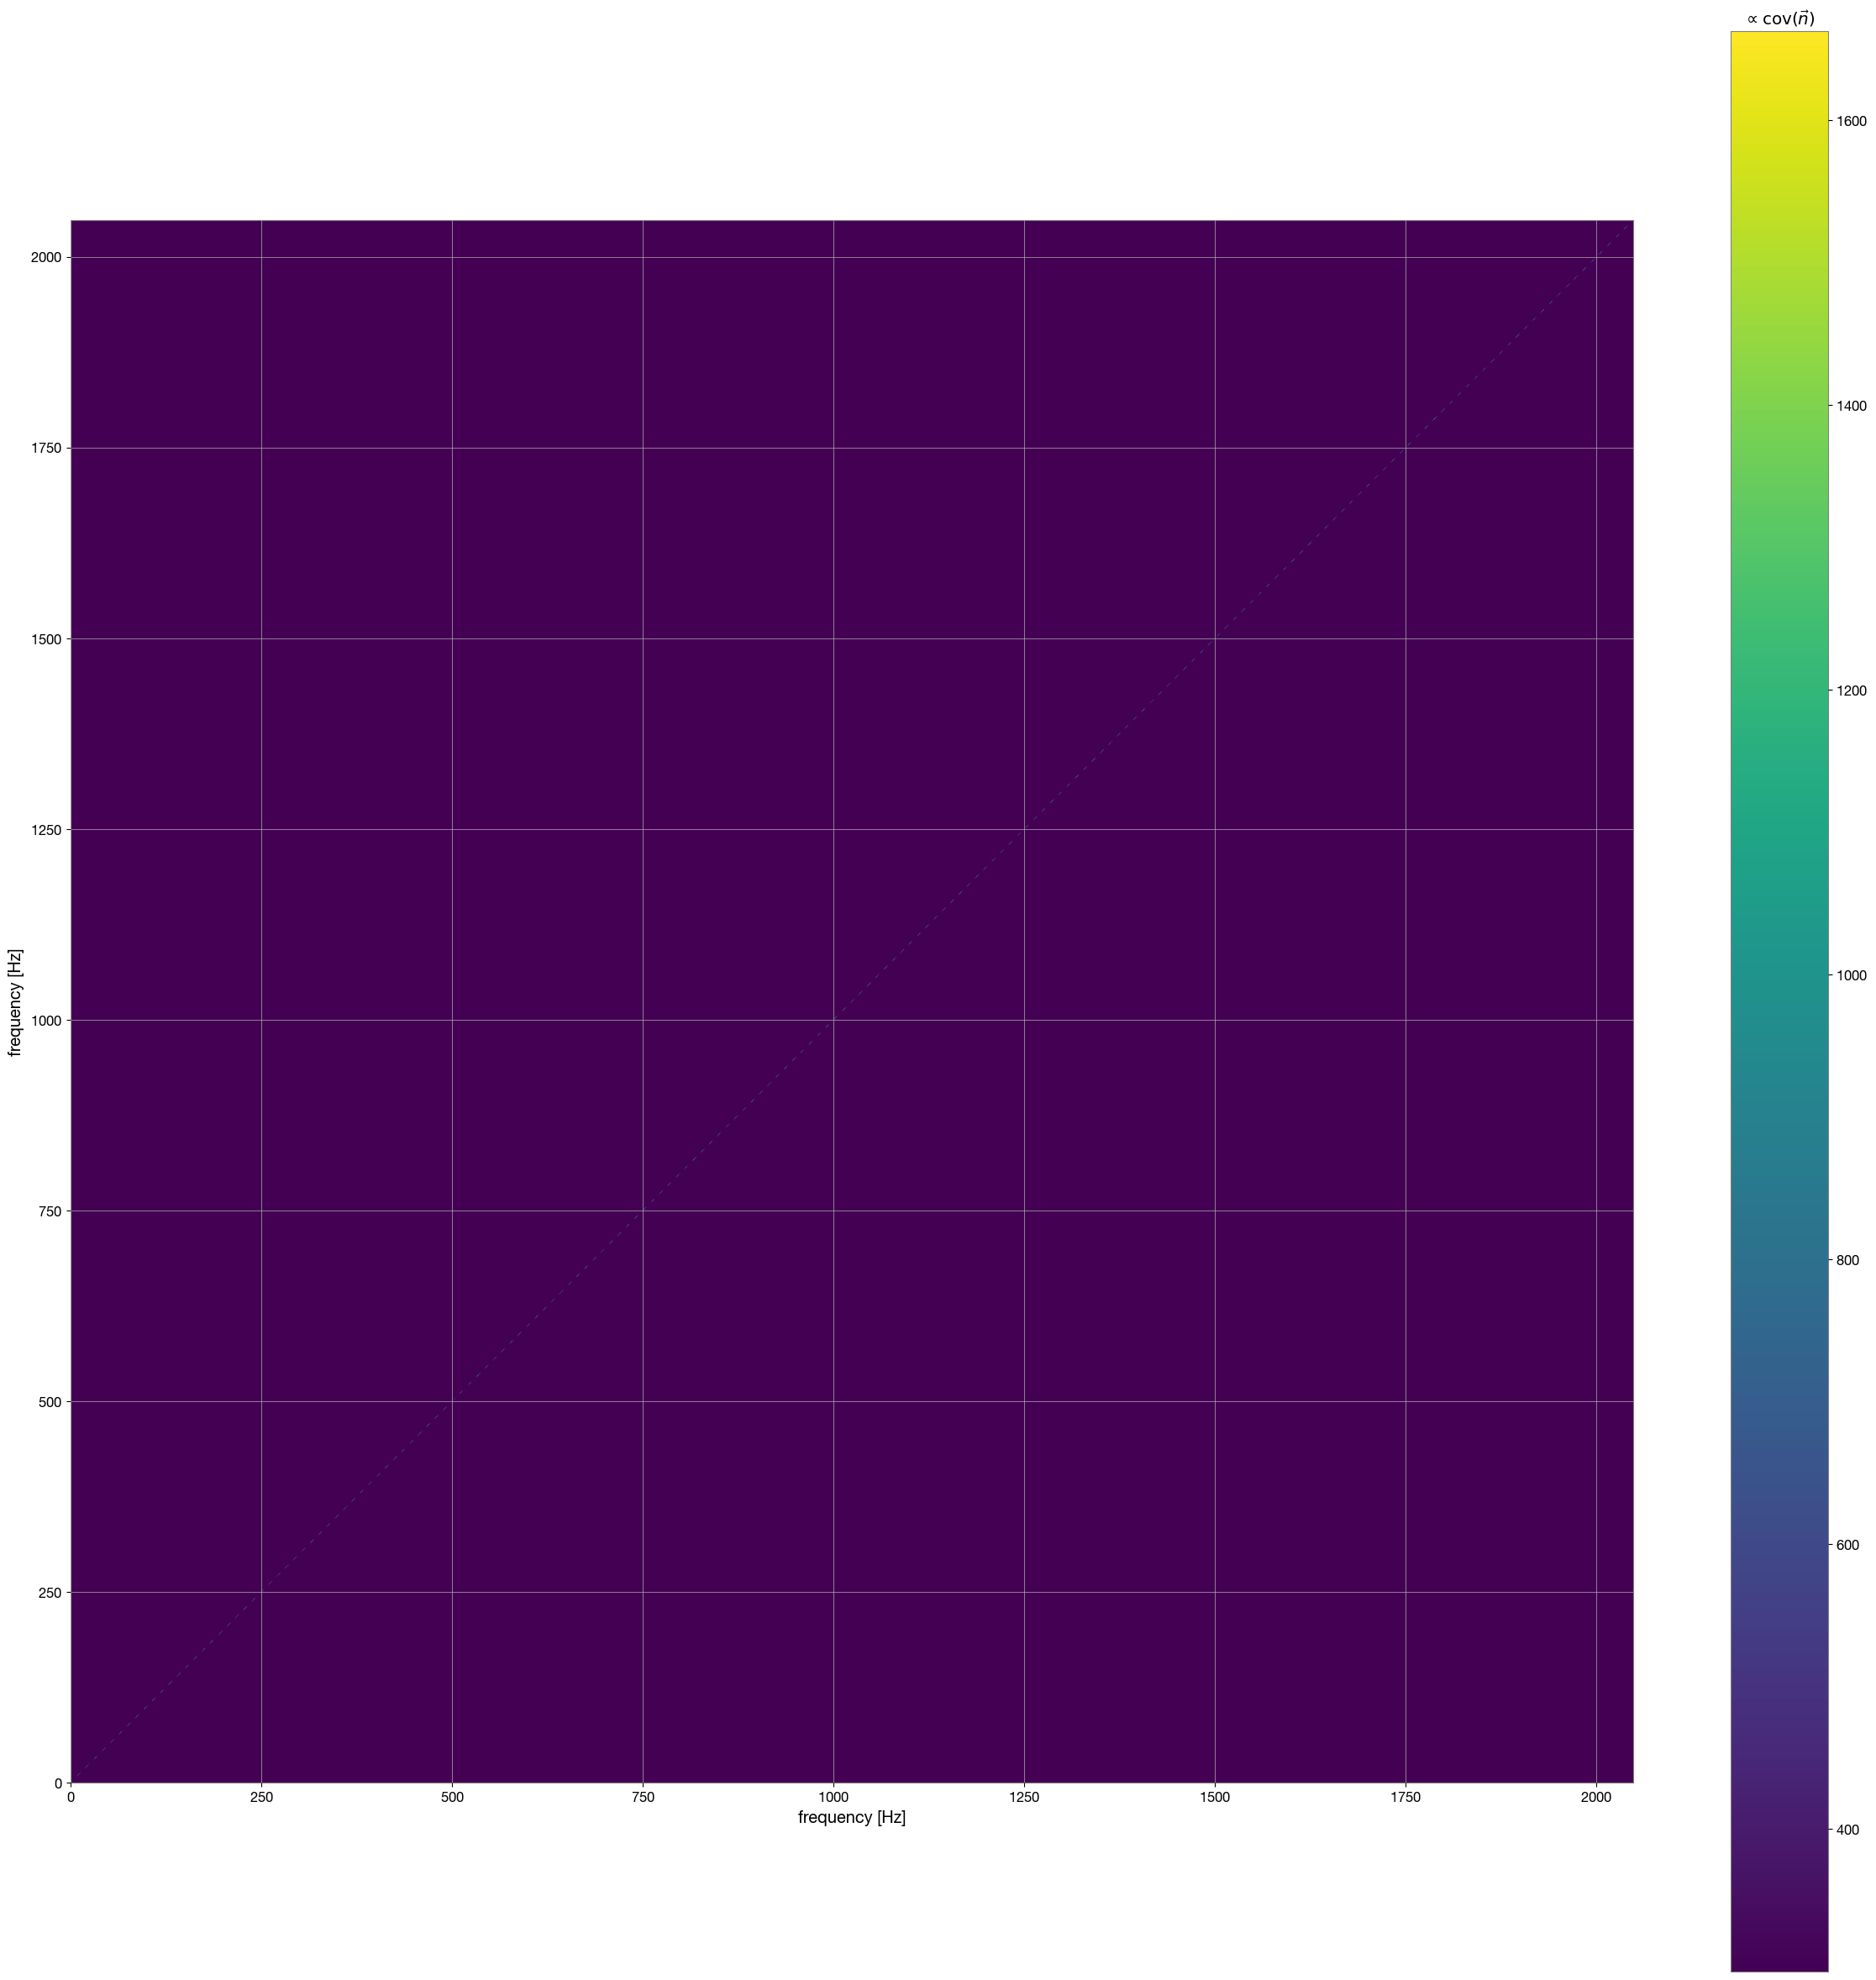

In [97]:
plt.figure(figsize=(30, 30))
plt.imshow(Σ, origin='lower',
           extent=[0, seg_freqs[-1], 0, seg_freqs[-1]],
           vmin=300)
plt.xlabel('frequency [Hz]')
plt.ylabel('frequency [Hz]')
cb = plt.colorbar()
cb.ax.set_title(r'$\propto\mathrm{cov}(\vec{n})$');

Nope.  The off-diagnals elements correspond to the covariance between differing frequency bins, and prove to be small.  The bright and roughly constant diagonal elements are yet another reflection of our noise being _white_.

# LIGO data

Now let's download some LIGO data and explore.


In [1]:
!wget -nc https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126259446-32.txt.gz

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
File ‘H-H1_LOSC_4_V2-1126259446-32.txt.gz’ already there; not retrieving.



In [17]:
h1_strain = np.loadtxt('H-H1_LOSC_4_V2-1126259446-32.txt.gz')
fs = 4096

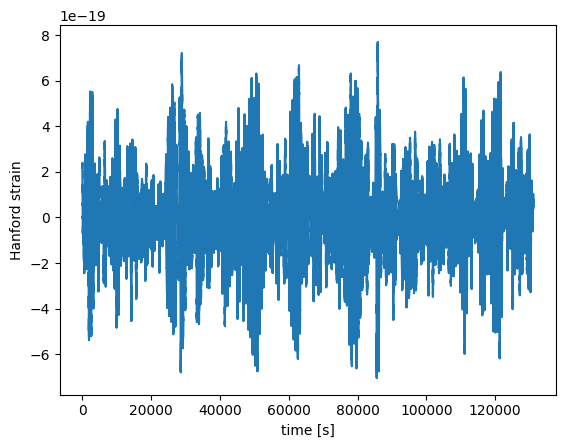

In [18]:
plt.plot(h1_strain)
plt.ylabel('Hanford strain')
plt.xlabel('time [s]');

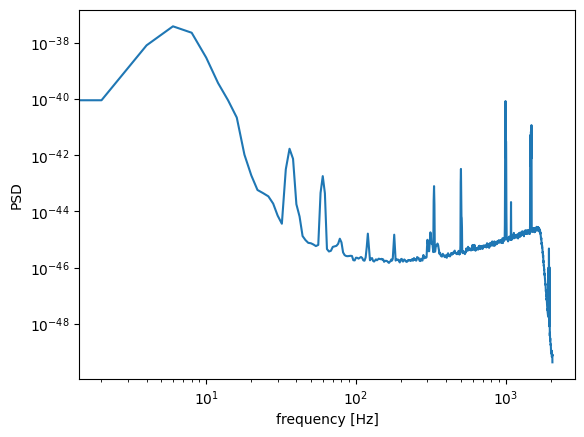

In [19]:
f, psd = signal.welch(h1_strain, fs, nperseg=.5*fs, scaling='spectrum')
plt.loglog(f, psd)
plt.ylabel('PSD')
plt.xlabel('frequency [Hz]');

We can see the noise is definitely not white.  There's particularly heavy noise at low frequencies from seismic activity, high frequencies from shot noise, and lot's of specral lines to boot.

We'll first try cleaning this up with a series of IIR filters, starting with a bandpass.

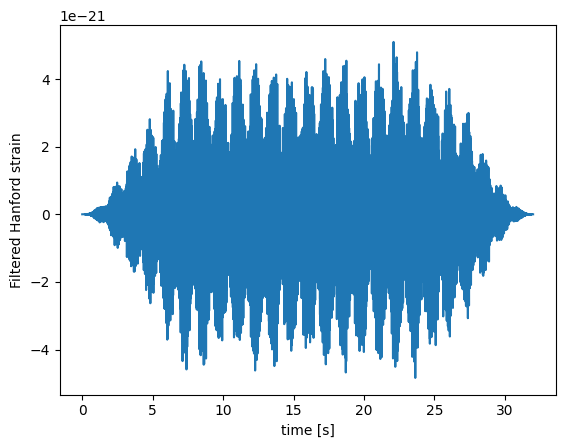

In [20]:
window = signal.tukey(len(h1_strain))
h1_fil = butter_bandpass_filter(window*h1_strain, 30, 500, fs)

ts = np.arange(len(h1_strain))/fs

plt.plot(ts, h1_fil)
plt.ylabel('Filtered Hanford strain')
plt.xlabel('time [s]');

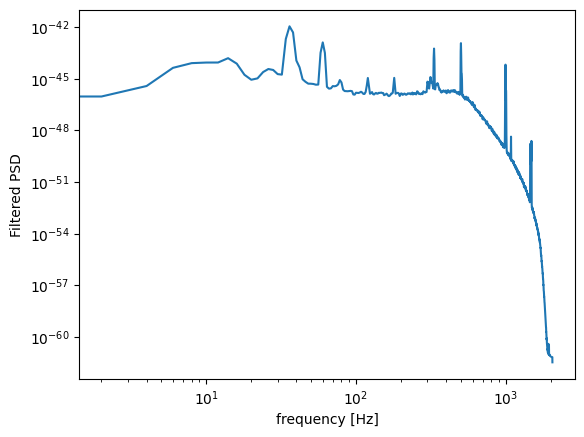

In [21]:
f, psd = signal.welch(h1_fil, fs, nperseg=.5*fs, scaling='spectrum')
plt.loglog(f, psd)
plt.ylabel('Filtered PSD')
plt.xlabel('frequency [Hz]');

Now let's start working on the spectral lines.  The collection of notches below was done by iteratively placing notches at the frequency corresponding to the PSD maximum and tweaking the quality factor until the line went away.

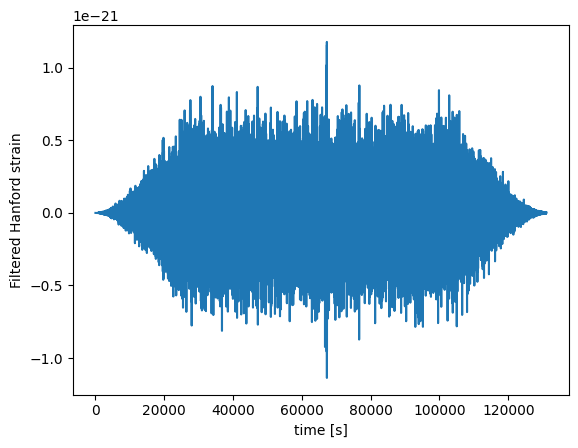

In [22]:
window = signal.tukey(len(h1_strain))
h1_fil = butter_bandpass_filter(window*h1_strain, 40, 500, fs, order=6)
h1_fil = iir_notch_filter(h1_fil, 60, fs, Q=60)
h1_fil = iir_notch_filter(h1_fil, 36, fs, Q=1)
h1_fil = iir_notch_filter(h1_fil, 502, fs, Q=30)
h1_fil = iir_notch_filter(h1_fil, 332, fs, Q=30)
h1_fil = iir_notch_filter(h1_fil, 314, fs, Q=30)

plt.plot(h1_fil)
plt.ylabel('Filtered Hanford strain')
plt.xlabel('time [s]');

180.0 Hz


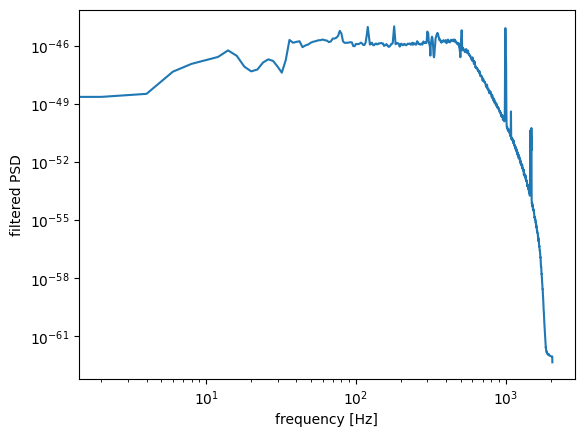

In [23]:
f, psd = signal.welch(h1_fil, fs, nperseg=.5*fs, scaling='spectrum')
plt.loglog(f, psd)
print(f[psd.argmax()], 'Hz')
plt.xlabel('frequency [Hz]')
plt.ylabel('filtered PSD');

That's pretty good.  Let's look at the filtered time series.

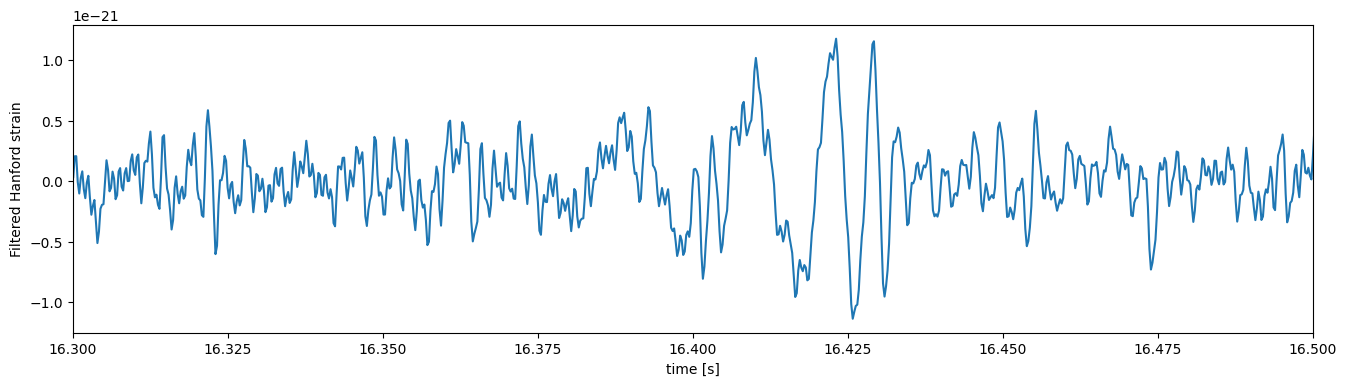

In [24]:
ts = np.arange(len(h1_strain))/fs

plt.figure(figsize=(16, 4))
plt.plot(ts, h1_fil)
plt.xlim(16.3, 16.5)
plt.xlabel('time [s]')
plt.ylabel('Filtered Hanford strain');

Boom!  There's the first direct detection of a gravitational wave, GW150914.  Let's download the Livingston data and repeat.

In [25]:
!wget -nc https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126259446-32.txt.gz

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
File ‘L-L1_LOSC_4_V2-1126259446-32.txt.gz’ already there; not retrieving.



In [26]:
l1_strain = np.loadtxt('L-L1_LOSC_4_V2-1126259446-32.txt.gz')

We needed a few more lines below.

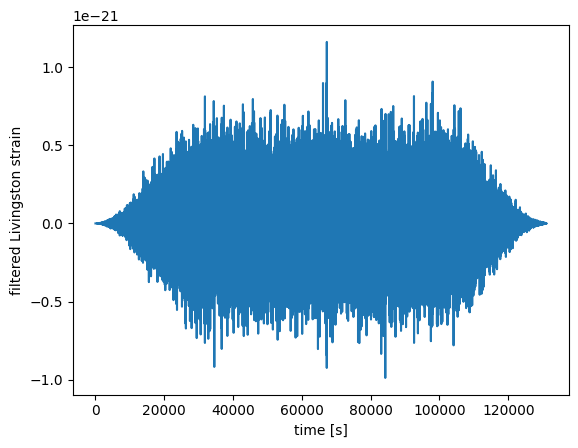

In [27]:
window = signal.tukey(len(l1_strain))
l1_fil = butter_bandpass_filter(window*l1_strain, 40, 500, fs, order=6)
l1_fil = iir_notch_filter(l1_fil, 60, fs, Q=60)
l1_fil = iir_notch_filter(l1_fil, 36, fs, Q=1)
l1_fil = iir_notch_filter(l1_fil, 502, fs, Q=30)
l1_fil = iir_notch_filter(l1_fil, 332, fs, Q=30)
l1_fil = iir_notch_filter(l1_fil, 314, fs, Q=30)
l1_fil = iir_notch_filter(l1_fil, 516, fs, Q=30)
l1_fil = iir_notch_filter(l1_fil, 510, fs, Q=15)
l1_fil = iir_notch_filter(l1_fil, 500, fs, Q=60)
l1_fil = iir_notch_filter(l1_fil, 180, fs, Q=60)
l1_fil = iir_notch_filter(l1_fil, 508, fs, Q=15)

plt.plot(l1_fil)
plt.xlabel('time [s]')
plt.ylabel('filtered Livingston strain');

332.0 Hz


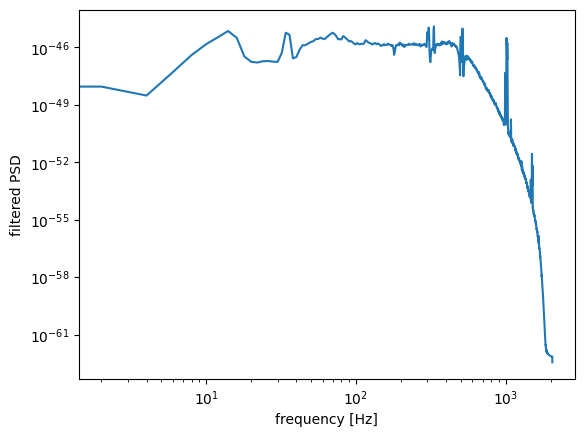

In [28]:
f, psd = signal.welch(l1_fil, fs, nperseg=.5*fs, scaling='spectrum')
plt.loglog(f, psd)
print(f[psd.argmax()], "Hz")
plt.xlabel('frequency [Hz]')
plt.ylabel('filtered PSD');

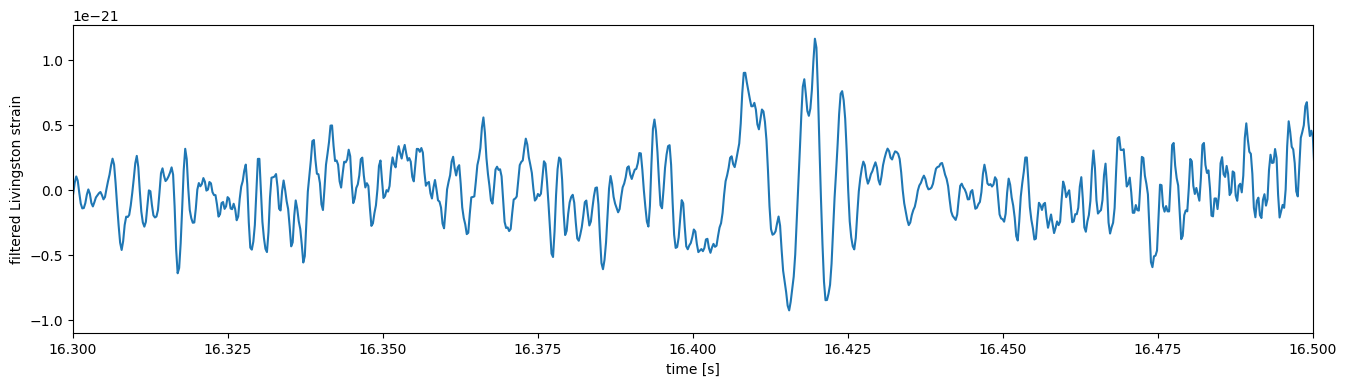

In [29]:
ts = np.arange(len(l1_strain))/fs

plt.figure(figsize=(16, 4))
plt.plot(ts, l1_fil)
plt.xlim(16.3, 16.5)
plt.xlabel('time [s]')
plt.ylabel('filtered Livingston strain');

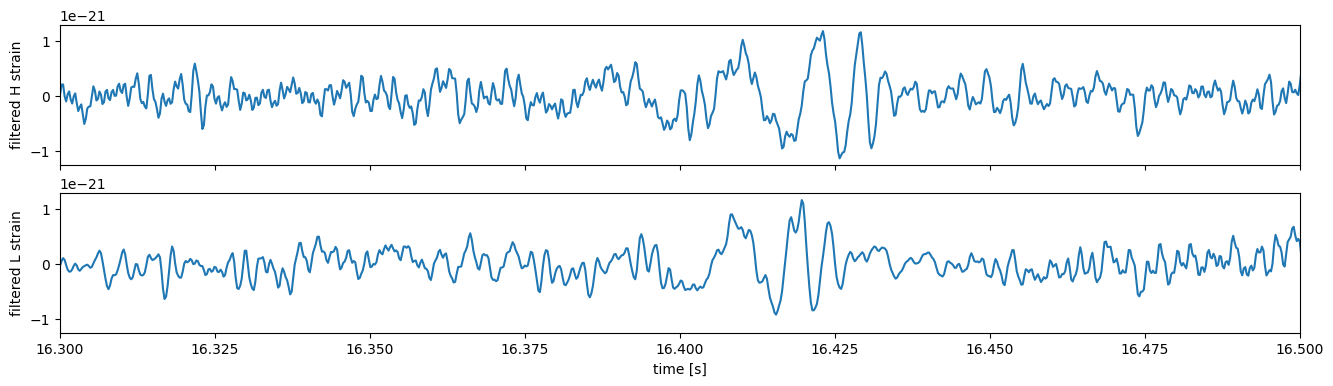

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(16, 4), sharex=True, sharey=True)

axs[0].plot(ts, h1_fil)
axs[1].plot(ts, l1_fil)
plt.xlim(16.3, 16.5)

axs[1].set_xlabel('time [s]')
axs[0].set_ylabel('filtered H strain')
axs[1].set_ylabel('filtered L strain');

We can even see the chirp structure characteristic of compact binary mergers in the spectrogram of the filtered time series.

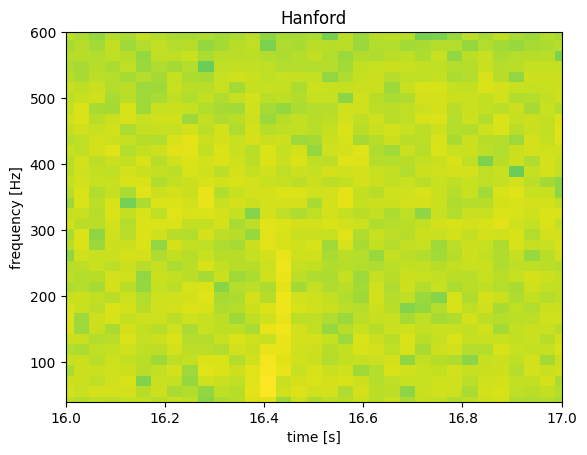

In [31]:
plt.specgram(h1_fil, Fs=fs, NFFT=256);
plt.ylim(40, 600)
plt.xlim(16, 17)
plt.title('Hanford')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]');

# Whitening
The process above was very hands-on, tuned, etc.  We can do better by using the PSD to _whiten_ the data.

In [32]:
from scipy import interp

Let's compute the PSD for the unfiltered strain, which we'll use the square root of for whitening.

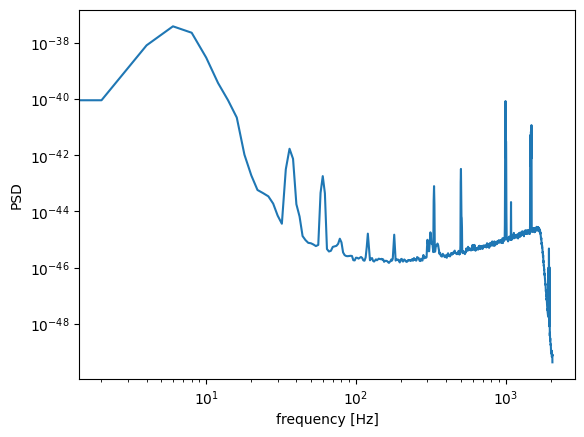

In [33]:
f, psd = signal.welch(h1_strain, fs, nperseg=.5*fs, scaling='spectrum')
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD');

The whitening process is super-simple.  We FFT the data, divide the frequency-domain data by the ASD, then inverse-FFT back to the time domain.  That's it (with the added step of interpolating the ASD since we don't have it at exactly the same frequencies as the data).

In [34]:
h1_strain_f = np.fft.rfft(window*h1_strain)
freqs = np.fft.rfftfreq(len(h1_strain), 1/fs)
asd = interp(freqs, f, np.sqrt(psd))
h1_white = np.fft.irfft(h1_strain_f/asd)

/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_44025/3437600974.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  asd = interp(freqs, f, np.sqrt(psd))


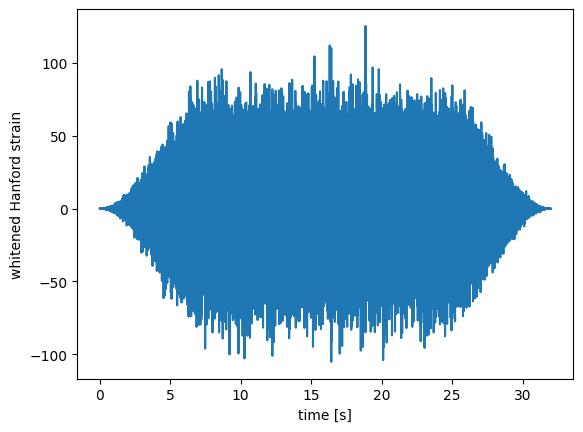

In [35]:
plt.plot(ts, h1_white)
plt.xlabel('time [s]')
plt.ylabel('whitened Hanford strain');

Text(0, 0.5, 'whitened PSD')

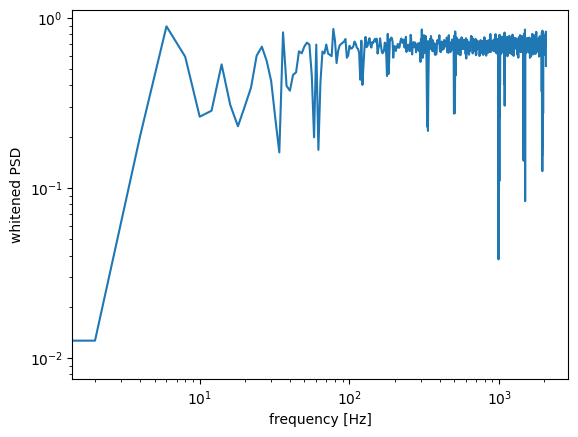

In [36]:
f, psd = signal.welch(h1_white, fs, nperseg=.5*fs, scaling='spectrum')
plt.loglog(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('whitened PSD')

A nice flat spectrum.  Let's take a look at the spectrogram, focusing on the part of the time series that wasn't affected by the window to keep the color range well-behaved.

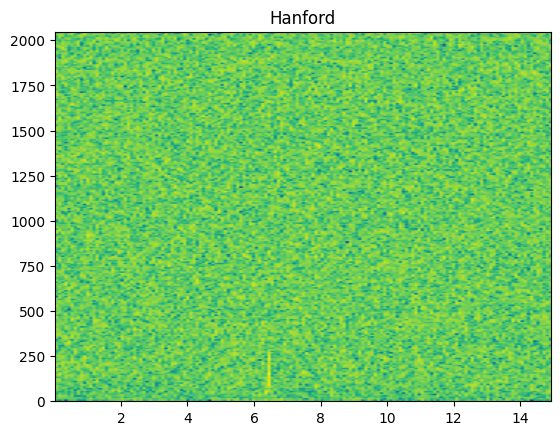

In [37]:
plt.specgram(h1_white[10*fs:25*fs], Fs=fs, NFFT=512);
# plt.ylim(40, 600)
# plt.xlim(16, 17)
plt.title('Hanford');

You can see the signal a little after 6 seconds!

# gwpy
All of these things can be done with one-liners using `gwpy`!

In [2]:
!pip install gwpy

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [38]:
from gwpy.timeseries import TimeSeries

In [39]:
start = 1126259446
h1_ts = TimeSeries(h1_strain, times=start+ts)

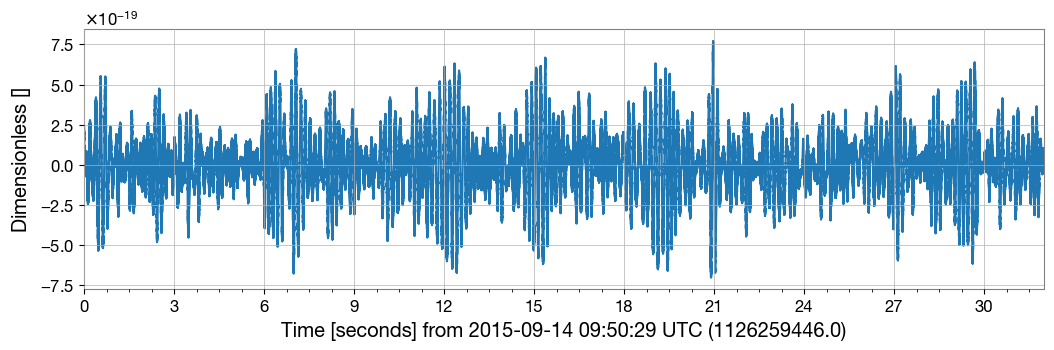

In [40]:
h1_ts.plot();

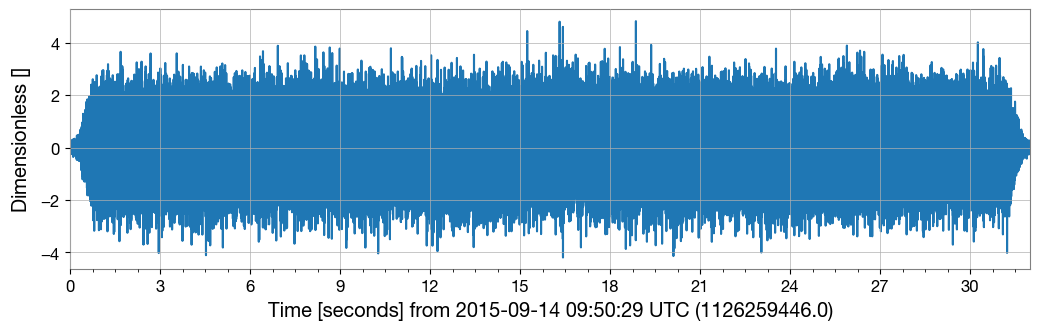

In [41]:
h1_ts.whiten().plot();

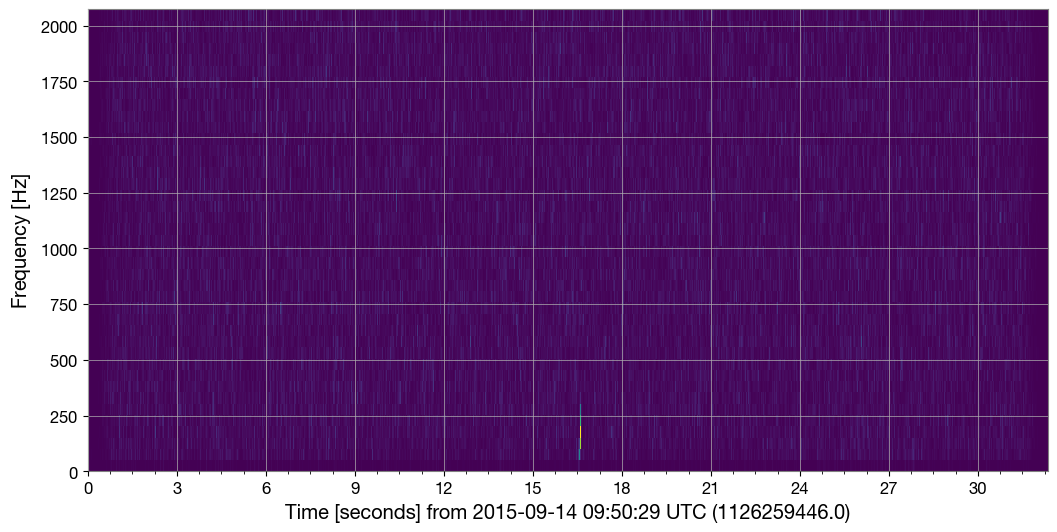

In [42]:
h1_ts.whiten().spectrogram(.02).plot();

And a q-transform for good measure!

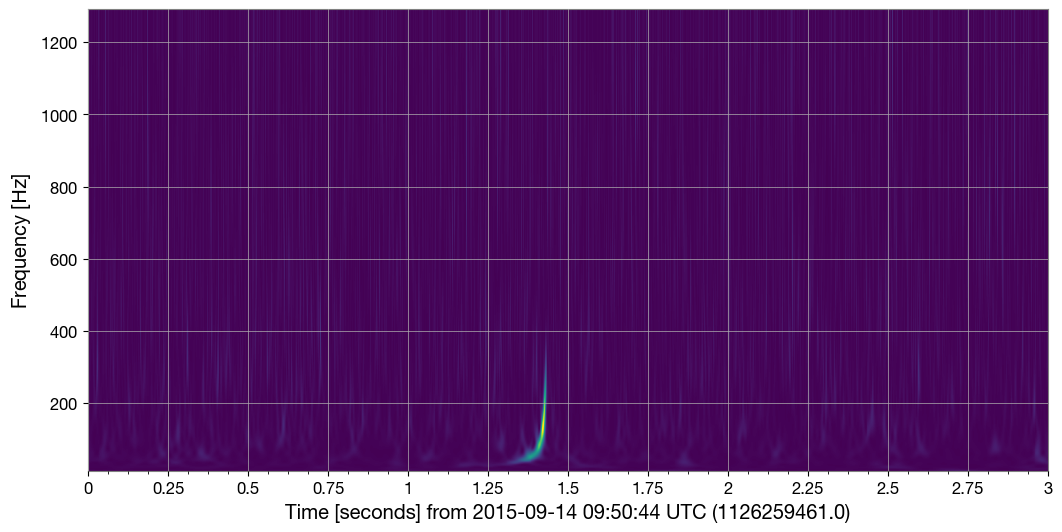

In [43]:
h1_ts.q_transform(outseg=[start+15, start+18]).plot();